# Ejemplo de uso de tranformer para traducción

El modelo de transformer está adapatado de "The Annotated Transformer" disponible en https://nlp.seas.harvard.edu/2018/04/03/attention.html

In [1]:
from transformer import transformer_model
import matplotlib.pyplot as plt
from collections import defaultdict
from elotl.corpus import load

In [2]:
#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in list(doc.strip())]

In [3]:
#Índices de símbolos especiales
PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2
OOV_IDX = 3

#Función para hacer padding
def insert_pad(lista, PAD_IDX=PAD_IDX):    
    l = max([len(cad) for cad in lista])
    pad_lista = []
    for cad in lista:
        pad_cad = cad + [PAD_IDX for i in range(l-len(cad))]
        pad_lista.append(pad_cad)
    return pad_lista

#Funcuón para insertar símbolos a las cadenas
def process_seqs(seqs,BOS_IDX=BOS_IDX,EOS_IDX=EOS_IDX):
    return insert_pad([[BOS_IDX] + cad + [EOS_IDX] for cad in seqs])

In [4]:
#Carcgar el corpus bilingüe
corpus = load('tsunkua')

src = [sent[0].lower() for sent in corpus if sent[3]=='PRONTUARIO EN  OTOMÍ  / ESPAÑOL HÑÄHÑU']
tgt = [sent[1].lower() for sent in corpus if sent[3]=='PRONTUARIO EN  OTOMÍ  / ESPAÑOL HÑÄHÑU']

print(list(zip(src,tgt)))

[('buenos días', "ki hats'i"), ('bienvenidos', 'hogä ehe'), ('muchas gracias', 'ndunthi di jämadi'), ('regresa pronto', "mänt'ä gi pengi"), ('buen provecho', 'nzaki'), ('mi nombre es', 'ma tuhu'), ('pase usted a descansar', 'thogi gi zi tsaya'), ('muchas gracias por su visita', 'ndunthi di jämadi po rá tso̱ni'), ('¡qué disfruten de esta reunión!', "ga ho ra hmunts'i"), ('con permiso, ya me voy', 'ko ri zi nseki, ya dá zi ma'), ('nos vemos pronto', 'ga nzenguahu̱'), ('nos vemos, buen camino', "ga k'athu, hoga 'ñu"), ('buenas tardes', 'ki dee, texki dee'), ('buenos días', 'haxa juä')]


In [5]:
#src = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
 #       'un gato come croquetas']
#tgt = ['DA NC V DD NC', 'DD NC V', 'DA NC V DA NC', 'DD NC V NC']

#Crear vobulario y cadenas
#Lenguaje fuente
src_voc = vocab()
src_voc['<PAD>'] = PAD_IDX
src_voc['<BOS>'] = BOS_IDX
src_voc['<EOS>'] = EOS_IDX
src_voc['<OOV>'] = OOV_IDX
src_cads = process_seqs(list(text2numba(src,src_voc)))

#Crear vocabulario y cadenas
#Lenguaje objetivo
tgt_voc = vocab()
tgt_voc['<PAD>'] = PAD_IDX
tgt_voc['<BOS>'] = BOS_IDX
tgt_voc['<EOS>'] = EOS_IDX
tgt_cads = process_seqs(list(text2numba(tgt,tgt_voc)))

#Longitudes de los vocabulario
len_src, len_tgt = len(src_voc), len(tgt_voc)

In [6]:
#Se genera el modelo en base a los hiperparámetros
model = transformer_model(len_src,len_tgt,N=1, d_model=128,d_ff=128,h=1)

100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


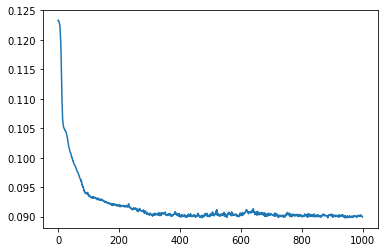

CPU times: user 7min 59s, sys: 649 ms, total: 7min 59s
Wall time: 1min 20s


In [7]:
%%time
#Entrenamiento del modelo
model.train(src_cads,tgt_cads,its=1000,batch_size=2)
#Plot de la pérdida
plt.plot(model.loss)
plt.show()

In [8]:
#Función para convertir cadenas en el formato adecuadi
def get_x_input(sents):
    x_sents = []
    for sent in sents:
        x_sent = []
        for c in list(sent):
            try: 
                idx_c = src_voc[c]
            except: 
                idx_c = src_voc[OOV_IDX]
            x_sent.append(idx_c)
        x_sents.append([BOS_IDX] + x_sent + [EOS_IDX])
        
    return x_sents

#Transformar salidas en palabras
tgt_voc_rev = {k:v for v,k in tgt_voc.items()}
def get_output(sent):
    return ''.join([tgt_voc_rev[word] for word in sent if word != 0])

In [9]:
sents = ['buen provecho', 'buenos provechos','bienvenido', 'binvenida', 'nombre', 'mis nombres', 'muchas gracias', 
         'muchas', 'muchas tardes', 'grcias muchs', 'mushas grasias']

for i,sent in enumerate(get_x_input(sents)):
    pred = model.predict([sent],BOS=BOS_IDX, max_len=100).tolist()
    print('{} --> {}'.format(sents[i],get_output(pred)))

buen provecho --> <BOS>nzaki<EOS>
buenos provechos --> <BOS>nzaki<EOS>
bienvenido --> <BOS>hogä ehe<EOS>
binvenida --> <BOS>hogä ehe<EOS>
nombre --> <BOS>ma tuhu<EOS>
mis nombres --> <BOS>ma tuhu<EOS>
muchas gracias --> <BOS>ndi di di jämadi<EOS>
muchas --> <BOS>ndi di di jämadi<EOS>
muchas tardes --> <BOS>nzaki<EOS>
grcias muchs --> <BOS>ndi di di jämadi<EOS>
mushas grasias --> <BOS>ndi hi di jämadi<EOS>
